In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import KFold, LeaveOneGroupOut, train_test_split

In [2]:
SEED = 42
N_JOBS = -1

## Load data

In [3]:
data = pd.read_csv("../data/data.csv")

X = data.drop(["timestamp", "label", "subject"], axis=1)
groups = data["subject"]
y = data["label"]

## Classifiers

In [4]:
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


def classify(split_name, X_train, y_train, X_test, y_test):
    classifiers_names = [
        "Nearest Neighbors",
        "Linear SVM",
        "RBF SVM",
        "Gaussian Process",
        "Decision Tree",
        "Random Forest",
        "Neural Net",
        "AdaBoost",
        "Naive Bayes",
        "Gradient Boosting",
    ]

    classifiers = [
        KNeighborsClassifier(n_neighbors=5, n_jobs=N_JOBS),
        SVC(kernel="linear", random_state=SEED),
        SVC(kernel="rbf", random_state=SEED),
        GaussianProcessClassifier(kernel=1.0 * RBF(1.0), n_jobs=N_JOBS, random_state=SEED),
        DecisionTreeClassifier(random_state=SEED),
        RandomForestClassifier(n_jobs=N_JOBS, random_state=SEED),
        MLPClassifier(max_iter=1000, random_state=SEED),
        AdaBoostClassifier(random_state=SEED),
        GaussianNB(),
        GradientBoostingClassifier(random_state=SEED),
    ]

    df = pd.DataFrame(columns=["classifier", "split_method", "accuracy", "precision", "recall", "f1"])
    for name, clf in zip(classifiers_names, classifiers):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        precision, recall, f_score, _ = precision_recall_fscore_support(
            y_test, y_pred, average="weighted", zero_division=0
        )
        df.loc[len(df)] = [name, split_name, acc, precision, recall, f_score]

    return df

# Train-Test Split
## Leave One Subject Out

In [5]:
logo = LeaveOneGroupOut()
logo_results = pd.DataFrame()
for train_index, test_index in logo.split(X, y, groups):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    df = classify("logo", X_train, y_train, X_test, y_test)
    logo_results = pd.concat([logo_results, df], ignore_index=True)

logo_results = (
    logo_results.groupby(by=["classifier", "split_method"])
    .mean()
    .reset_index()
    .sort_values("accuracy", ascending=False)
)
logo_results

,classifier,split_method,accuracy,precision,recall,f1
5,Naive Bayes,logo,0.854848,0.875413,0.854848,0.848197
9,Random Forest,logo,0.799134,0.853291,0.799134,0.769756
3,Gradient Boosting,logo,0.692643,0.707600,0.692643,0.618351
1,Decision Tree,logo,0.655792,0.715480,0.655792,0.596046
4,Linear SVM,logo,0.549699,0.572592,0.549699,0.453815
0,AdaBoost,logo,0.512616,0.524618,0.512616,0.431654
7,Neural Net,logo,0.477500,0.499053,0.477500,0.396058
2,Gaussian Process,logo,0.462975,0.556742,0.462975,0.366532
6,Nearest Neighbors,logo,0.414227,0.381629,0.414227,0.340757
8,RBF SVM,logo,0.361917,0.340893,0.361917,0.298057


## 10-Fold

In [6]:
kf_10 = KFold(n_splits=10, shuffle=True, random_state=SEED)
kf_10_results = pd.DataFrame()
for train_index, test_index in kf_10.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    df = classify("10-fold", X_train, y_train, X_test, y_test)
    kf_10_results = pd.concat([kf_10_results, df], ignore_index=True)

kf_10_results = (
    kf_10_results.groupby(by=["classifier", "split_method"])
    .mean()
    .reset_index()
    .sort_values("accuracy", ascending=False)
)
kf_10_results

,classifier,split_method,accuracy,precision,recall,f1
1,Decision Tree,10-fold,0.984480,0.985181,0.984480,0.984472
3,Gradient Boosting,10-fold,0.979285,0.980505,0.979285,0.979313
9,Random Forest,10-fold,0.976721,0.977684,0.976721,0.976725
5,Naive Bayes,10-fold,0.968961,0.970145,0.968961,0.968995
2,Gaussian Process,10-fold,0.963765,0.965963,0.963765,0.963965
0,AdaBoost,10-fold,0.963698,0.965505,0.963698,0.963383
6,Nearest Neighbors,10-fold,0.961066,0.964231,0.961066,0.961022
4,Linear SVM,10-fold,0.958300,0.961373,0.958300,0.958219
7,Neural Net,10-fold,0.958232,0.960189,0.958232,0.957567
8,RBF SVM,10-fold,0.916734,0.928588,0.916734,0.914150


## Compare results

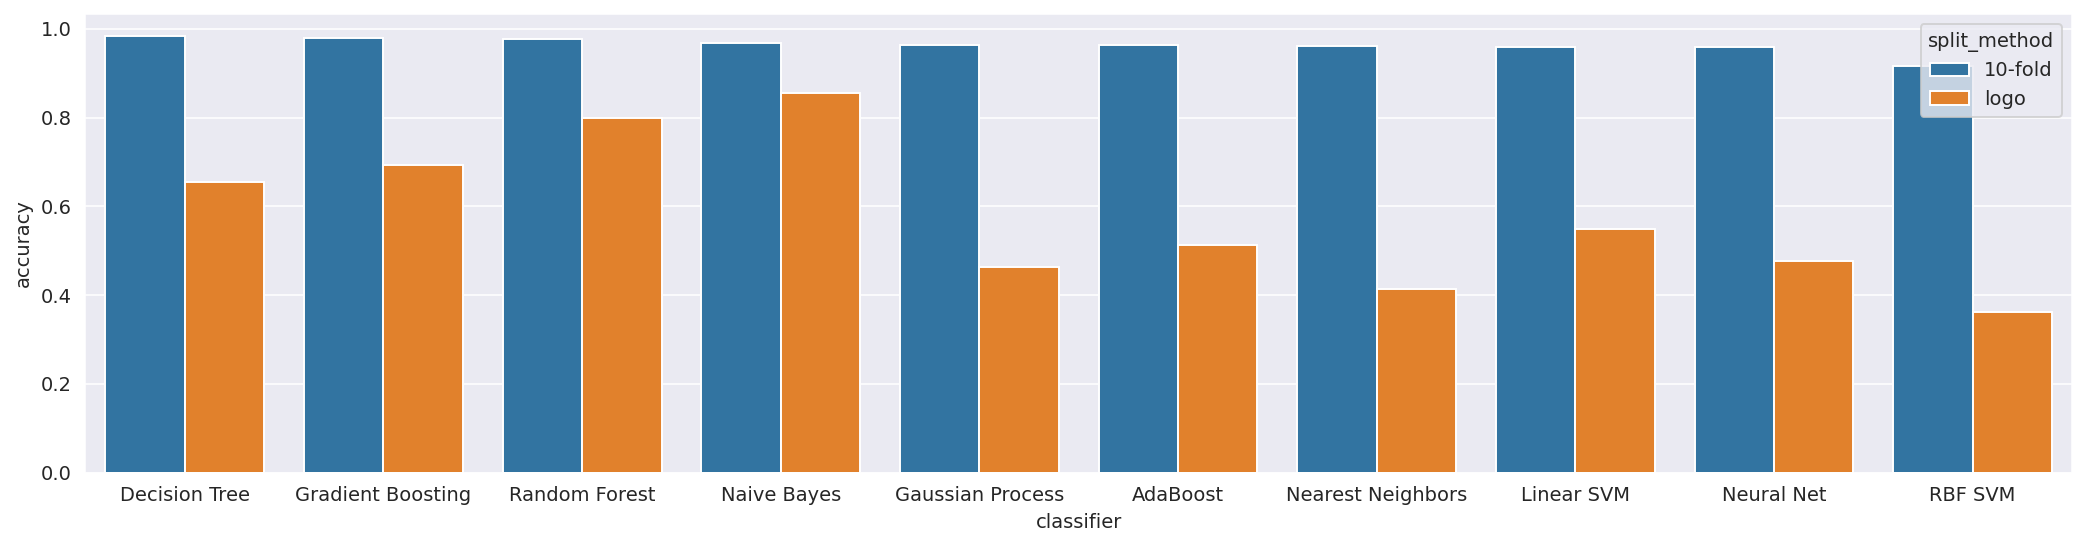

In [7]:
cv_results = pd.concat([kf_10_results, logo_results])
fig, ax = plt.subplots(figsize=(15, 4), dpi=140)
sns.barplot(x="classifier", y="accuracy", hue="split_method", data=cv_results, ax=ax)
fig.tight_layout()
plt.show()

The best classifier regarding 10-fold is a decision tree. The 10-fold performs better than the LOSO for all tested classification algorithms. So we choose a decision tree for our application.

# Feature Subset

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED, stratify=y)

In [9]:
clf = DecisionTreeClassifier(random_state=SEED)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy =", accuracy_score(y_test, y_pred))

Accuracy = 0.935064935064935


In [10]:
print("Tree depth =", clf.get_depth())

Tree depth = 4


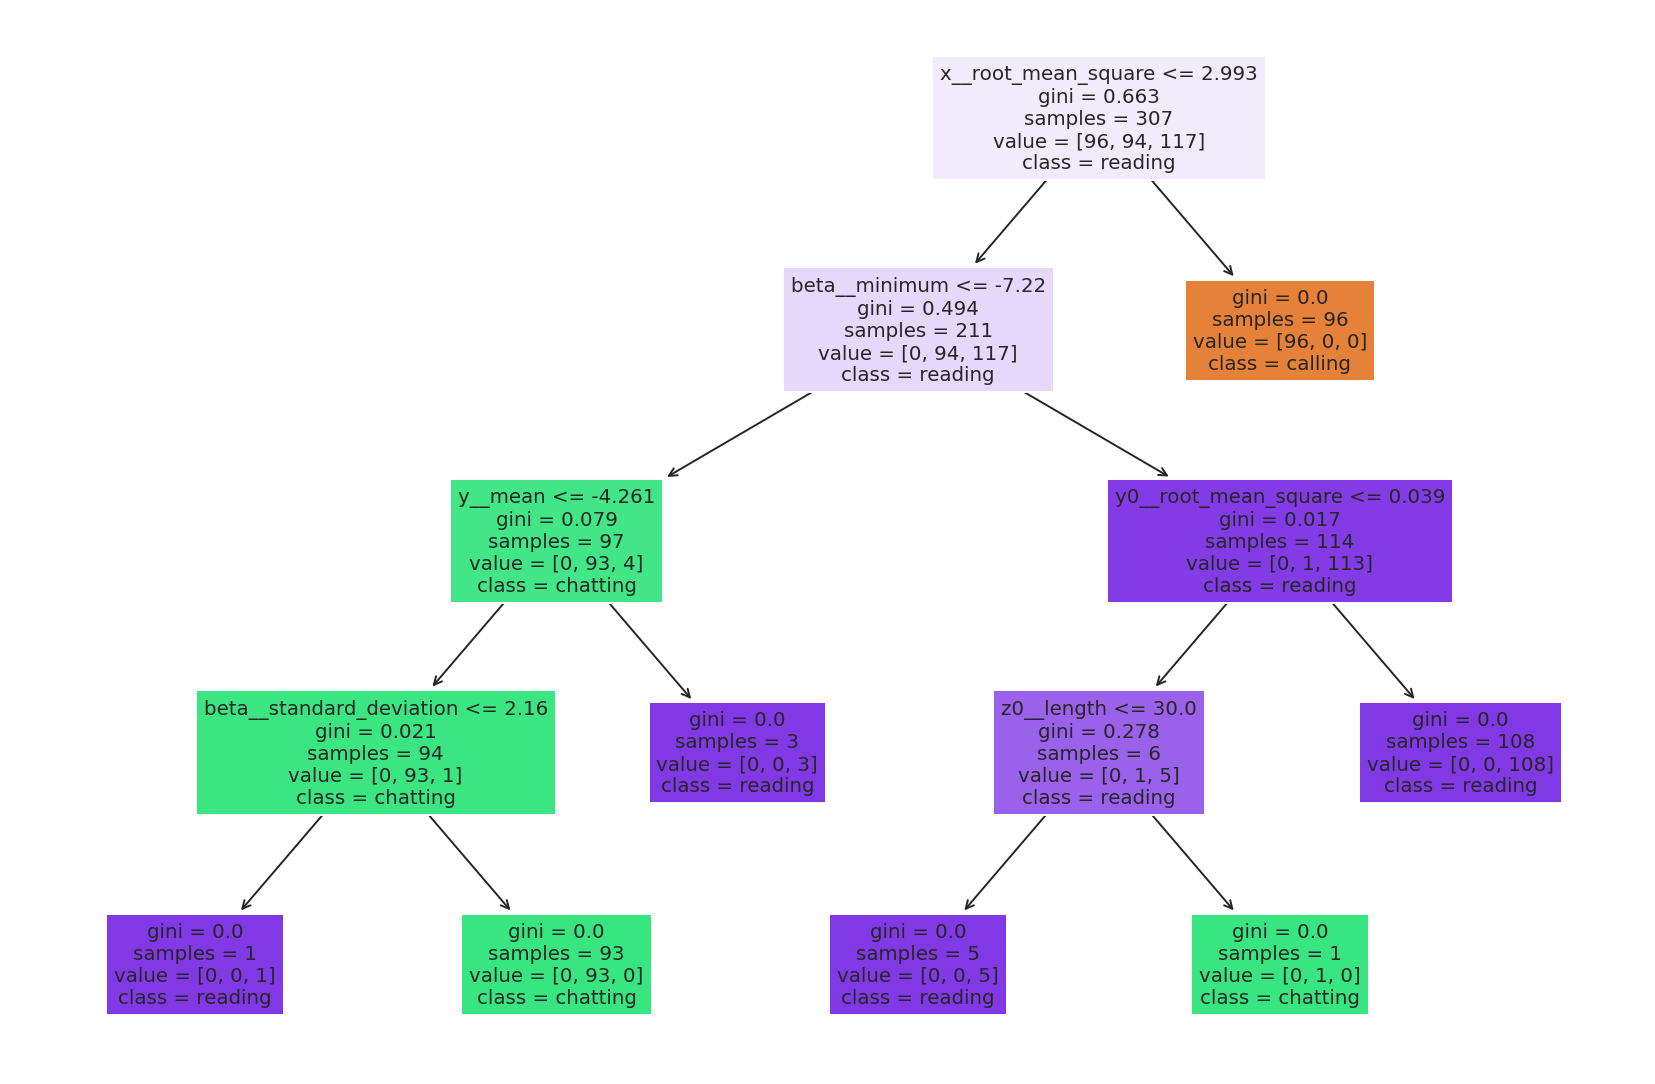

In [11]:
fig, ax = plt.subplots(figsize=(15, 10), dpi=140)
_ = tree.plot_tree(
    clf, ax=ax, feature_names=X_train.columns, class_names=["calling", "chatting", "reading"], filled=True
)

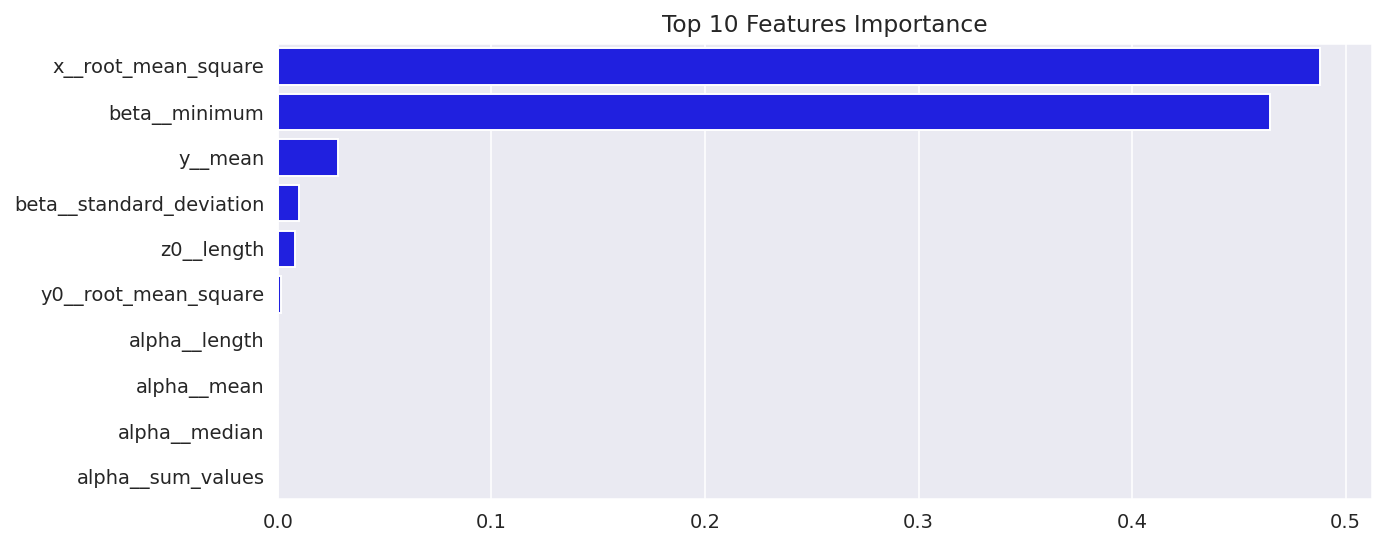

In [12]:
features_idx = (-clf.feature_importances_).argsort()[:10]
fig, ax = plt.subplots(figsize=(10, 4), dpi=140)
sns.barplot(x=clf.feature_importances_[features_idx], y=X_train.columns[features_idx], ax=ax, orient="h", color="b")
ax.set_title("Top 10 Features Importance")
fig.tight_layout()
plt.show()

### Select features with non-zero importance

In [13]:
selected_features = X_train.columns[features_idx][clf.feature_importances_[features_idx].astype(bool)].to_list()
selected_features

Index(['x__root_mean_square', 'beta__minimum', 'y__mean',
       'beta__standard_deviation', 'z0__length', 'y0__root_mean_square'],
      dtype='object')

In [14]:
classify("stratified_train_test", X_train[selected_features], y_train, X_test[selected_features], y_test).drop(
    columns="split_method"
).sort_values("accuracy", ascending=False)

,classifier,accuracy,precision,recall,f1
9,Gradient Boosting,0.974026,0.975702,0.974026,0.973894
6,Neural Net,0.961039,0.964692,0.961039,0.960698
8,Naive Bayes,0.961039,0.964692,0.961039,0.960698
1,Linear SVM,0.948052,0.954349,0.948052,0.947366
7,AdaBoost,0.948052,0.949385,0.948052,0.947788
3,Gaussian Process,0.935065,0.944614,0.935065,0.933866
4,Decision Tree,0.935065,0.944614,0.935065,0.933866
5,Random Forest,0.935065,0.944614,0.935065,0.933866
0,Nearest Neighbors,0.922078,0.928094,0.922078,0.922289
2,RBF SVM,0.909091,0.926768,0.909091,0.908282



# Recursive Feature Elimination

In [15]:
classifiers_names = ["Linear SVM", "Decision Tree", "Random Forest", "AdaBoost", "Gradient Boosting"]

classifiers = [
    SVC(kernel="linear", random_state=SEED),
    DecisionTreeClassifier(random_state=SEED),
    RandomForestClassifier(n_jobs=N_JOBS, random_state=SEED),
    AdaBoostClassifier(random_state=SEED),
    GradientBoostingClassifier(random_state=SEED),
]

elimination_results = pd.DataFrame(columns=["classifier", "features", "accuracy"])

for name, clf in zip(classifiers_names, classifiers):
    selector = RFE(clf, n_features_to_select=len(selected_features))
    selector = selector.fit(X_train, y_train)
    selected_features = X_train.columns[selector.support_].to_list()
    clf.fit(X_train[selected_features], y_train)
    y_pred = clf.predict(X_test[selected_features])
    elimination_results.loc[len(elimination_results)] = [name, selected_features, accuracy_score(y_test, y_pred)]

elimination_results.sort_values("accuracy", ascending=False)

,classifier,features,accuracy
1,Decision Tree,"[y0__root_mean_square, z0__variance, y__mean, ...",0.974026
3,AdaBoost,"[x__root_mean_square, y__root_mean_square, z__...",0.961039
0,Linear SVM,"[y0__sum_values, z__minimum, alpha__median, be...",0.948052
2,Random Forest,"[z0__standard_deviation, z0__variance, x__root...",0.948052
4,Gradient Boosting,"[z0__standard_deviation, x__standard_deviation...",0.948052


The RFE algorithm provides a different set of features than the one we chose, but the validation shows that the performance on this subset is better than when using our selected subset or all the features.

## Get the most frequently selected features

In [16]:
rfe_features = [j for i in elimination_results["features"].to_list() for j in i]
features_frequency = {x: rfe_features.count(x) for x in rfe_features}
features_frequency = dict(sorted(features_frequency.items(), key=lambda item: item[1], reverse=True))
features_frequency

{'z__minimum': 4,
 'x__root_mean_square': 3,
 'z__maximum': 3,
 'z0__variance': 2,
 'z0__standard_deviation': 2,
 'beta__minimum': 2,
 'z__root_mean_square': 2,
 'y0__sum_values': 1,
 'alpha__median': 1,
 'beta__standard_deviation': 1,
 'gamma__root_mean_square': 1,
 'gamma__minimum': 1,
 'y0__root_mean_square': 1,
 'y__mean': 1,
 'beta__length': 1,
 'beta__root_mean_square': 1,
 'y__root_mean_square': 1,
 'x__standard_deviation': 1,
 'x__variance': 1}

In [17]:
new_selected_features = elimination_results[elimination_results["classifier"] == "Decision Tree"]["features"].to_list()[
    0
]
new_selected_features

['y0__root_mean_square',
 'z0__variance',
 'y__mean',
 'z__minimum',
 'beta__length',
 'beta__root_mean_square']

## Save dataset with selected features

In [18]:
new_data = data[new_selected_features + ["label"]]
new_data.to_csv("../data/clean_data.csv", index=False)